In [1]:
import heapq
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Callable, Optional
from noise import snoise2

# Code

In [2]:
def get_neighbors(current: Tuple[int, int], shape: Tuple[int, int], radius: int = 2) -> List[Tuple[int, int]]:
    x, y = current
    neighbors = []
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            if dx == 0 and dy == 0:
                continue  # Skip the current position
            nx, ny = x + dx, y + dy
            if 0 <= nx < shape[0] and 0 <= ny < shape[1]:
                # Check if the point is within the circular radius
                if math.sqrt(dx**2 + dy**2) <= radius:
                    neighbors.append((nx, ny))
    return neighbors


def astar_heightmap(
    heightmap: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
    heuristic: Callable[[Tuple[int, int], Tuple[int, int]], float],
    cost_function: Callable[[np.ndarray, Tuple[int, int], Tuple[int, int]], float]
) -> List[Tuple[int, int]]:
    heap = [(0, start)]
    came_from = {}
    cost_so_far = {start: 0}
    shape = heightmap.shape

    while heap:
        _, current = heapq.heappop(heap)
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        for next in get_neighbors(current, shape):
            new_cost = cost_so_far[current] + cost_function(heightmap, current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = 0.1 * new_cost + heuristic(next, goal)
                heapq.heappush(heap, (priority, next))
                came_from[next] = current
    
    return []  # No path found

In [3]:
def downsample_heightmap(heightmap, target_height, target_width):
    current_height, current_width = heightmap.shape
    
    # Calculate the downsampling factors
    height_factor = current_height // target_height
    width_factor = current_width // target_width
    
    # Ensure the factors are at least 1
    height_factor = max(1, height_factor)
    width_factor = max(1, width_factor)
    
    # Calculate the new dimensions
    new_height = current_height // height_factor
    new_width = current_width // width_factor
    
    # Reshape and mean
    reshaped = heightmap[:new_height*height_factor, :new_width*width_factor]
    reshaped = reshaped.reshape(new_height, height_factor, new_width, width_factor)
    downsampled = reshaped.mean(axis=(1, 3))
    
    return downsampled

In [4]:
def plot_heightmap_and_path(heightmap_data, path=None, start=None, finish=None):
    plt.figure(figsize=(12, 8))
    
    # Plot the heightmap
    im = plt.imshow(heightmap_data, cmap='gist_earth', vmin=0)
    plt.colorbar(label='Elevation', orientation='horizontal')
    
    # Plot start point
    if start:
        plt.plot(start[1], start[0], 'go', markersize=10, label='Start')
    
    # Plot finish point
    if finish:
        plt.plot(finish[1], finish[0], 'ro', markersize=10, label='Finish')
    
    # Plot path
    if path is not None:
        try:
            if isinstance(path, (list, tuple)) and len(path) > 0:
                if isinstance(path[0], (list, tuple)) and len(path[0]) == 2:
                    # Path is a list of coordinate tuples
                    path_y, path_x = zip(*path)
                    plt.plot(path_x, path_y, linestyle='-', color='white', linewidth=2, label='Path')
                elif isinstance(path[0], int):
                    # Path is a flat list of alternating y and x coordinates
                    path_y = path[::2]
                    path_x = path[1::2]
                    plt.plot(path_x, path_y, linestyle='-', color='white', linewidth=2, label='Path')
                else:
                    print("Warning: Path format not recognized. Unable to plot path.")
            else:
                print("Warning: Path is empty. Unable to plot path.")
        except Exception as e:
            print(f"Error plotting path: {e}")
    
    plt.title('Heightmap with Path')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [5]:
def plot_heightmap_and_paths(
    heightmap_data: np.ndarray,
    paths: List[List[Tuple[int, int]]],
    start: Optional[Tuple[int, int]] = None,
    finish: Optional[Tuple[int, int]] = None,
    path_labels: Optional[List[str]] = None,
    path_colors: Optional[List[str]] = None
):
    plt.figure(figsize=(12, 8))
    
    # Plot the heightmap
    im = plt.imshow(heightmap_data, cmap='gist_earth', vmin=0)
    plt.colorbar(label='Elevation', orientation='horizontal')
    
    # Plot start point
    if start:
        plt.plot(start[1], start[0], 'go', markersize=10, label='Start')
    
    # Plot finish point
    if finish:
        plt.plot(finish[1], finish[0], 'ro', markersize=10, label='Finish')
    
    # Default colors if not provided
    if path_colors is None:
        path_colors = plt.cm.rainbow(np.linspace(0, 1, len(paths)))
    
    # Default labels if not provided
    if path_labels is None:
        path_labels = [f'Path {i+1}' for i in range(len(paths))]
    
    # Plot paths
    for i, path in enumerate(paths):
        if path:
            path_y, path_x = zip(*path)
            plt.plot(path_x, path_y, linestyle='-', color=path_colors[i], linewidth=2, label=path_labels[i])
    
    plt.title('Heightmap with Multiple Paths')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Examples

Time taken to find the path: 0.6652 seconds


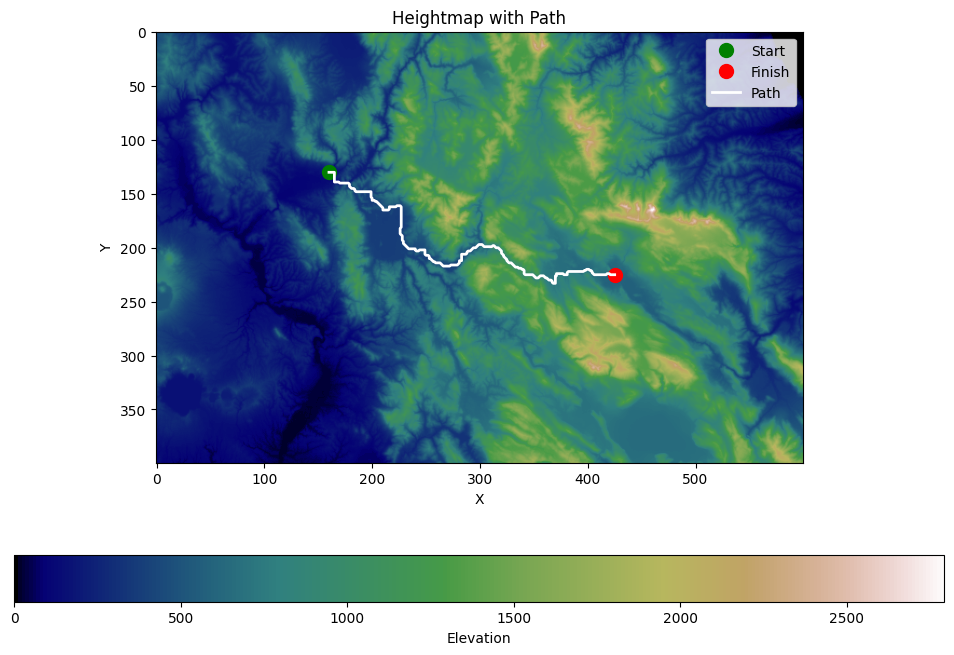

In [20]:
# Heuristic
def euclidean_distance(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

# Cost
def height_difference_cost(heightmap: np.ndarray, current: Tuple[int, int], next: Tuple[int, int]) -> float:
    height_diff = abs(heightmap[next] - heightmap[current])
    return height_diff + 1  # Add base cost to prefer shorter paths
    
# Load the heightmap
heightmap = np.load("heightmaps/italia_4000_6000_heightmap_wo_norm.npy")
heightmap = downsample_heightmap(heightmap, 400, 600)


# Define start and goal points
start = (130, 160)
goal = (225, 425)

# Measure the time to find the path
start_time = time.time()
path = astar_heightmap(heightmap, start, goal, euclidean_distance, height_difference_cost)
end_time = time.time()

# Print the time taken
print(f"Time taken to find the path: {end_time - start_time:.4f} seconds")

# Plot the result
plot_heightmap_and_path(heightmap, path, start, goal)

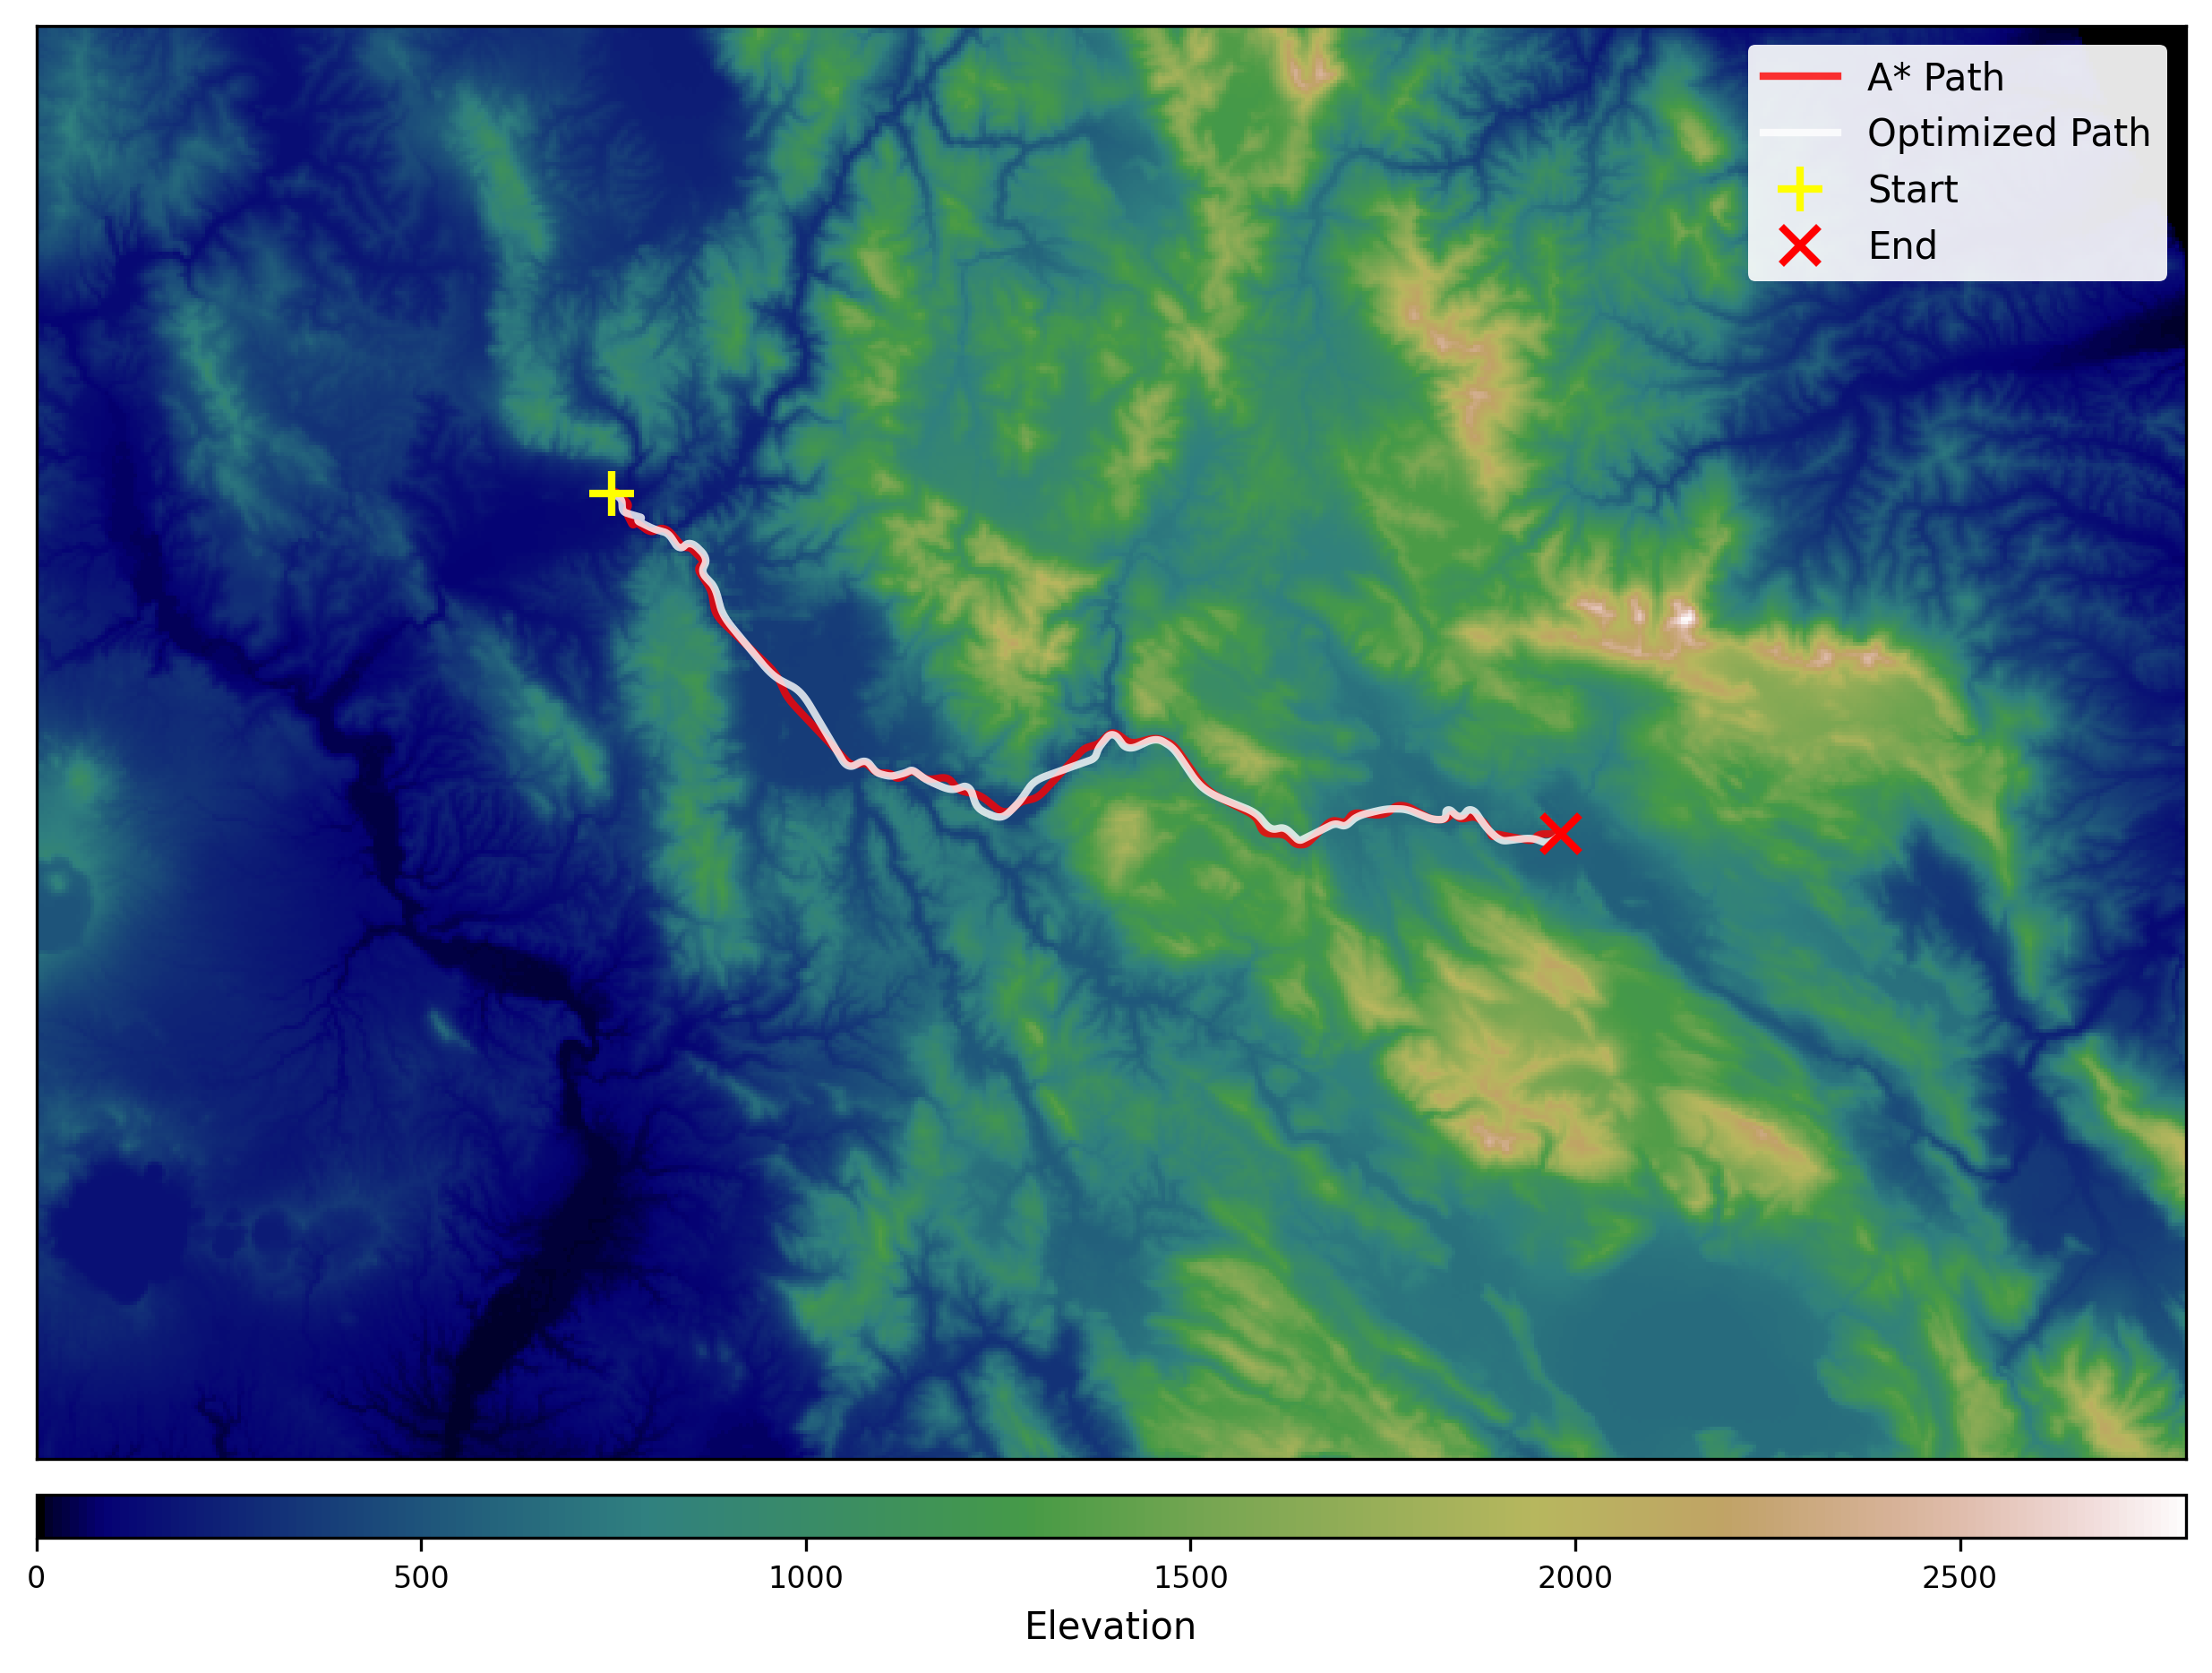

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch

def plot_paths_heightmap(heightmap, astar_path, optimized_path, title="Path Comparison on Heightmap", 
                        save_path=None, figsize=(10, 8), dpi=300):
    """
    Create a publication-ready plot comparing two paths on a heightmap.
    
    Parameters:
    -----------
    heightmap : np.ndarray
        2D array containing the heightmap data
    astar_path : np.ndarray
        Nx2 array containing the coordinates of the A* path
    optimized_path : np.ndarray
        Nx2 array containing the coordinates of the optimized path
    title : str, optional
        Plot title
    save_path : str, optional
        If provided, saves the plot to this path
    figsize : tuple, optional
        Figure size in inches
    dpi : int, optional
        DPI for the output figure
    """
    # Create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # Create main axis for the plot with minimal spacing for colorbar
    ax = fig.add_axes([0.1, 0.05, 0.8, 0.8])
    
    # Plot heightmap
    im = ax.imshow(heightmap, cmap='gist_earth', vmin=0, aspect='equal')
    
    # Plot paths with updated styles
    ax.plot(astar_path[:, 1], astar_path[:, 0], 
            'r-', linewidth=2, label='A* Path', alpha=0.8)  # Changed to continuous line
    ax.plot(optimized_path[:, 1], optimized_path[:, 0], 
            'w-', linewidth=2, label='Optimized Path', alpha=0.8)
    
    # Add start and end markers with new symbols
    ax.plot(astar_path[0, 1], astar_path[0, 0], '+', 
            color='yellow', markersize=12, markeredgewidth=2, 
            label='Start', zorder=5)  # Changed to yellow plus
    ax.plot(astar_path[-1, 1], astar_path[-1, 0], 'x', 
            color='red', markersize=10, markeredgewidth=2, 
            label='End', zorder=5)  # Changed to red x
    
    # Customize axis
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(title, pad=20, fontsize=12, fontweight='bold')
    
    # Add legend
    legend = ax.legend(loc='upper right', framealpha=0.9, 
                      facecolor='white', edgecolor='none',
                      fontsize=10)
    legend.get_frame().set_facecolor('white')
    
    # Add colorbar with minimal spacing
    cax = fig.add_axes([0.1, 0.08, 0.8, 0.02])
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label('Elevation', fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
        
    return fig, ax

# Example usage:
if __name__ == "__main__":
    # Load the heightmap
    heightmap = np.load("heightmaps/italia_4000_6000_heightmap_wo_norm.npy")
    heightmap = downsample_heightmap(heightmap, 400, 600)

    run = 'graceful-dust-8'
    astar_path = np.load(f'results/{run}/astar_path.npy')
    optimized_path = np.load(f'results/{run}/optimized_astar_path.npy')
    
    # Create plot
    fig, ax = plot_paths_heightmap(heightmap, astar_path, optimized_path, save_path=f'{run}_path_comparison.pdf')
    plt.show()

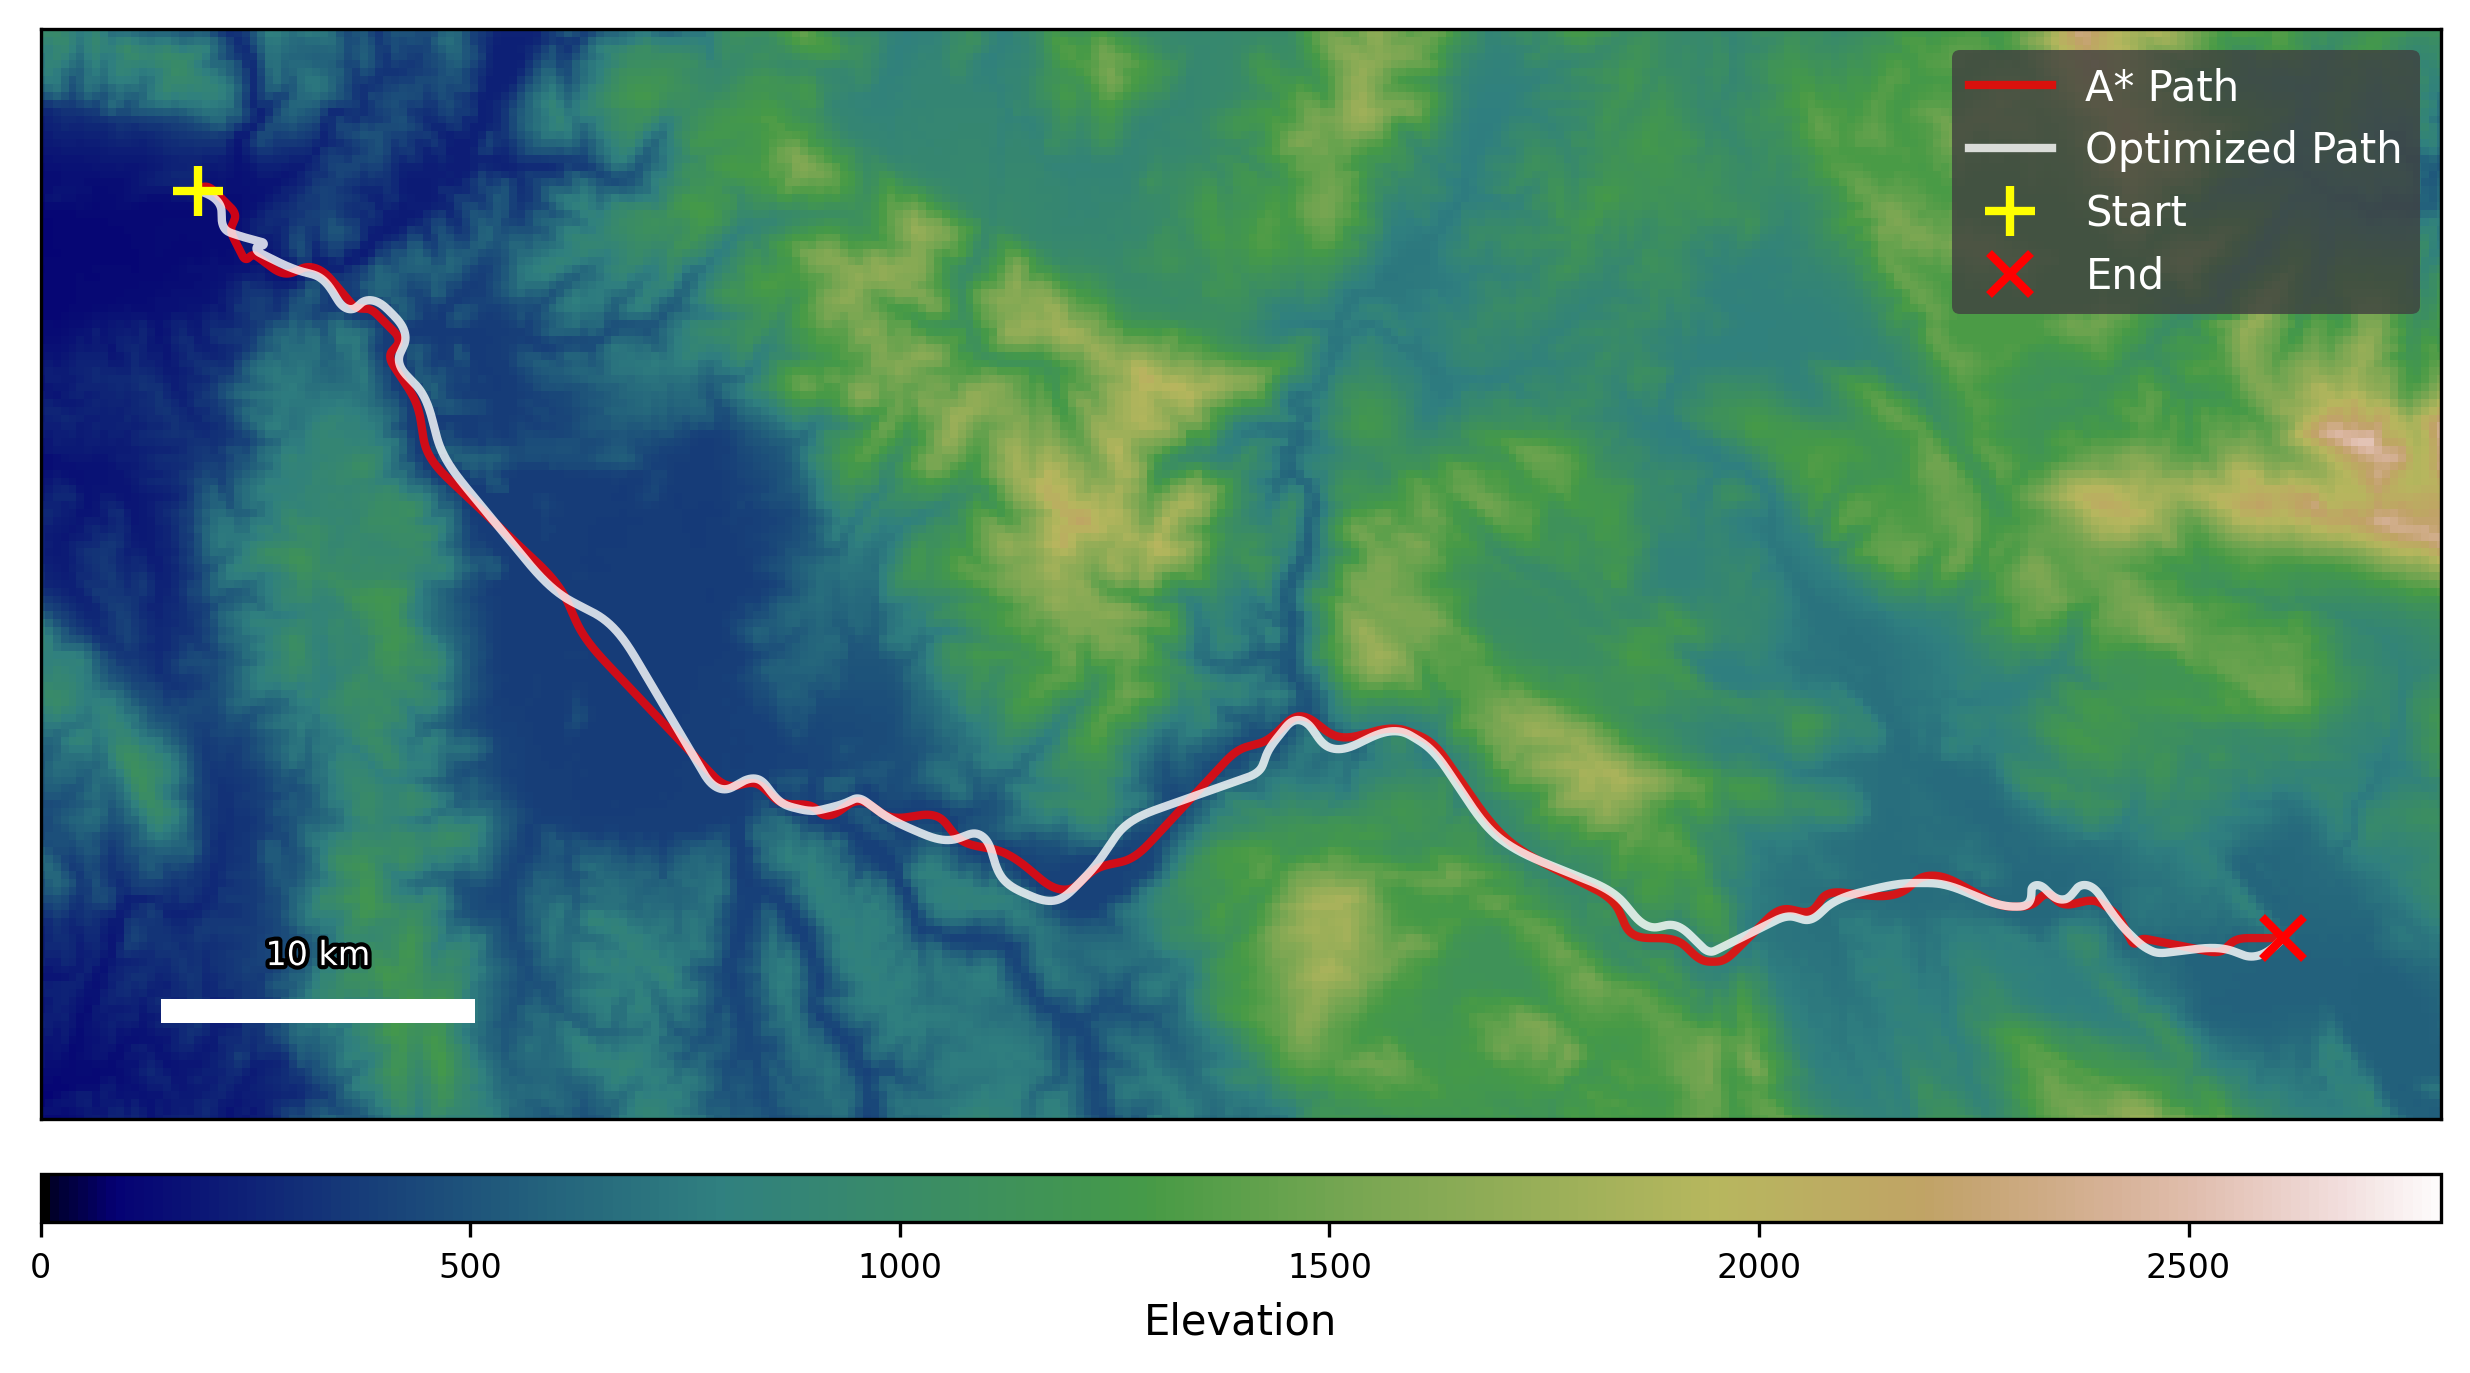

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch, Rectangle
from matplotlib import patheffects

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch, Rectangle
from matplotlib import patheffects

def plot_paths_heightmap(heightmap, astar_path, optimized_path, original_size=(2000, 2000),
                        title="Path Comparison on Heightmap", 
                        save_path=None, figsize=(10, 8), dpi=300, padding=20,
                        scale_position='lower-right'):
    """
    Create a publication-ready plot comparing two paths on a heightmap with zoom functionality.
    Original scale: 2000x2000 pixels = 50x50 km, adjusted for downsampling
    
    Parameters:
    -----------
    heightmap : np.ndarray
        2D array containing the heightmap data (downsampled)
    astar_path : np.ndarray
        Nx2 array containing the coordinates of the A* path
    optimized_path : np.ndarray
        Nx2 array containing the coordinates of the optimized path
    original_size : tuple
        Original size of the heightmap before downsampling (height, width)
    title : str, optional
        Plot title
    save_path : str, optional
        If provided, saves the plot to this path
    figsize : tuple, optional
        Figure size in inches
    dpi : int, optional
        DPI for the output figure
    padding : int, optional
        Number of pixels to pad around the path bounds for zoom
    scale_position : str, optional
        Position of the scale bar. Options: 'lower-right', 'lower-left', 
        'upper-right', 'upper-left'
    """
    # Calculate downsampling factor
    downsample_factor = original_size[0] / heightmap.shape[0]
    
    # Create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # Create main axis for the plot with minimal spacing for colorbar
    ax = fig.add_axes([0.1, 0.05, 0.8, 0.8])
    
    # Calculate zoom bounds
    all_points = np.vstack([astar_path, optimized_path])
    min_y, max_y = all_points[:, 0].min(), all_points[:, 0].max()
    min_x, max_x = all_points[:, 1].min(), all_points[:, 1].max()
    
    # Add padding to bounds
    min_y = max(0, min_y - padding)
    max_y = min(heightmap.shape[0], max_y + padding)
    min_x = max(0, min_x - padding)
    max_x = min(heightmap.shape[1], max_x + padding)
    
    # Plot heightmap
    im = ax.imshow(heightmap, cmap='gist_earth', vmin=0, aspect='equal')
    
    # Set zoom limits
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(max_y, min_y)  # Reversed because imshow origin is top
    
    # Calculate visible region size in original coordinates
    visible_width = max_x - min_x
    visible_height = max_y - min_y
    
    # Calculate scale for the visible region
    # Original scale: 2000 pixels = 50 km
    # Need to account for both downsampling and zoom
    visible_region_km = (visible_width / heightmap.shape[1]) * (50 * original_size[1] / 2000)
    pixels_per_km = visible_width / visible_region_km
    
    # Plot paths with updated styles
    ax.plot(astar_path[:, 1], astar_path[:, 0], 
            'r-', linewidth=2, label='A* Path', alpha=0.8)
    ax.plot(optimized_path[:, 1], optimized_path[:, 0], 
            'w-', linewidth=2, label='Optimized Path', alpha=0.8)
    
    # Add start and end markers
    ax.plot(astar_path[0, 1], astar_path[0, 0], '+', 
            color='yellow', markersize=12, markeredgewidth=2, 
            label='Start', zorder=5)
    ax.plot(astar_path[-1, 1], astar_path[-1, 0], 'x', 
            color='red', markersize=10, markeredgewidth=2, 
            label='End', zorder=5)
    
    # Customize axis
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add legend with darker background
    legend = ax.legend(loc='upper right', framealpha=0.8,
                      facecolor='#404040', edgecolor='none',
                      fontsize=10)
    # Set legend text color to white for better contrast
    for text in legend.get_texts():
        text.set_color('white')
    
    # Add colorbar with minimal spacing
    cax = fig.add_axes([0.1, 0.18, 0.8, 0.02])
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label('Elevation', fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    # Add scale bar
    # Choose scale length based on visible region
    scale_length_km = max(1, min(10, visible_region_km / 5))  # Adaptive scale length
    scale_length_km = np.round(scale_length_km, 1)  # Round to 1 decimal place
    scale_length_pixels = scale_length_km * pixels_per_km
    
    # Position scale bar based on scale_position parameter
    scale_width = scale_length_pixels
    scale_height = 3  # Pixels
    padding_pixels = visible_width * 0.05  # 5% of visible width as padding
    
    # Calculate scale bar position based on chosen corner
    if scale_position == 'lower-right':
        scale_x = max_x - scale_width - padding_pixels
        scale_y = max_y - padding_pixels
        text_y_offset = -padding_pixels/2
        text_valign = 'top'
    elif scale_position == 'lower-left':
        scale_x = min_x + padding_pixels
        scale_y = max_y - padding_pixels
        text_y_offset = -padding_pixels/2
        text_valign = 'top'
    elif scale_position == 'upper-right':
        scale_x = max_x - scale_width - padding_pixels
        scale_y = min_y + padding_pixels
        text_y_offset = padding_pixels/2
        text_valign = 'bottom'
    elif scale_position == 'upper-left':
        scale_x = min_x + padding_pixels
        scale_y = min_y + padding_pixels
        text_y_offset = padding_pixels/2
        text_valign = 'bottom'
    else:
        raise ValueError("scale_position must be one of: 'lower-right', 'lower-left', 'upper-right', 'upper-left'")
    
    # Draw scale bar
    rect = Rectangle((scale_x, scale_y), scale_width, scale_height, 
                    facecolor='white', edgecolor='none')
    ax.add_patch(rect)
    
    # Add scale text
    ax.text(scale_x + scale_width/2, scale_y + text_y_offset, 
            f'{scale_length_km} km', 
            color='white', 
            horizontalalignment='center',
            verticalalignment=text_valign,
            fontsize=8,
            path_effects=[patheffects.withStroke(linewidth=2, 
                                               foreground='black')])
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
        
    return fig, ax

# Example usage:
if __name__ == "__main__":
    # Load and downsample the heightmap
    heightmap = np.load("heightmaps/italia_4000_6000_heightmap_wo_norm.npy")
    heightmap = downsample_heightmap(heightmap, 400, 600)

    run = 'graceful-dust-8'
    astar_path = np.load(f'results/{run}/astar_path.npy')
    optimized_path = np.load(f'results/{run}/optimized_astar_path.npy')
    
    # Create plot with scale in upper-left corner
    fig, ax = plot_paths_heightmap(heightmap, astar_path, optimized_path,
                                 original_size=(4000, 6000),
                                 scale_position='lower-left',  # Choose corner here
                                 save_path=f'{run}_path_comparison.pdf',
                                 padding=20)
    plt.show()